###  PRCP 1001 Rice Leaf Disease Prediction

In [1]:
#description 
The dataset contains 120 jpg images of disease infected rice leaves .The images are grouped into 3 classes based on the type of disease.There are 40 images in eac class.

Classes are :
    * Leaf smut
    * Brown spot
    * Bacterial leaf blight
#Performing the 

In [2]:
import os
import zipfile
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Load and Unzip  the data

In [3]:
#unzip files directly in the notebook
#List of zip files
zip_files = ['Bacterial leaf blight.zip', 'Brown spot.zip', 'Leaf smut.zip']

# Unzip each file
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        folder_name = zip_file.replace('.zip', '')  # Folder name based on the zip file name
        zip_ref.extractall(folder_name)


#### Check the folder Structure
structure inside the each folder

In [4]:
import os

for folder in ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']:
    print(f"\nContents of {folder}:")
    print(os.listdir(folder)[:5])  # Show first 5 files in each folder



Contents of Bacterial leaf blight:
['Bacterial leaf blight']

Contents of Brown spot:
['Brown spot']

Contents of Leaf smut:
['Leaf smut']


#### Organize into a common Dataset folder

In [5]:
import shutil

# Creating main dataset directory
os.makedirs('rice_leaf_dataset', exist_ok=True)

# Moving each disease folder inside rice_leaf_dataset
for folder in ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']:
    shutil.move(folder, f'rice_leaf_dataset/{folder}')


####  Using ImageDataGenerator to Load Images

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create datagenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Train and validation generators
train_generator = datagen.flow_from_directory(
    'rice_leaf_dataset',
    target_size=(150, 150),  # or whatever your CNN input size is
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'rice_leaf_dataset',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 96 images belonging to 3 classes.
Found 23 images belonging to 3 classes.


## EDA for Rice Leaf Disease

#### Check for  the Class Distribution

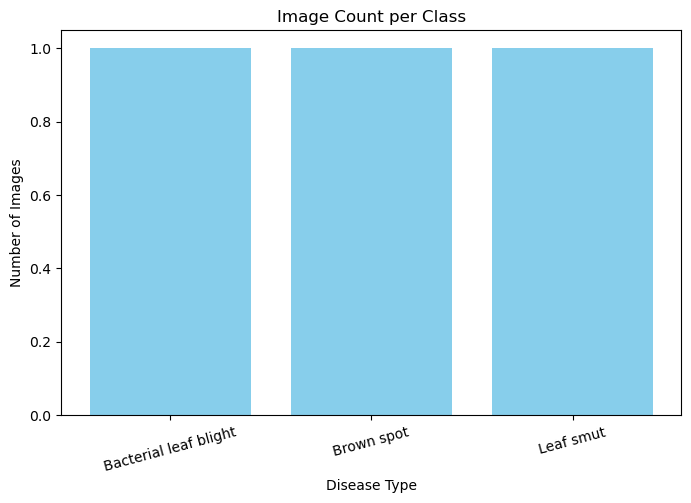

In [7]:
import os
import matplotlib.pyplot as plt

base_dir = 'rice_leaf_dataset'

# Getting class names and count images in each class
class_names = os.listdir(base_dir)
class_counts = {cls: len(os.listdir(os.path.join(base_dir, cls))) for cls in class_names}

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Image Count per Class")
plt.xlabel("Disease Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.show()


In [ ]:
#sa

In [10]:
#nested file error
import os

class_path = 'rice_leaf_dataset/Bacterial leaf blight'
print(os.listdir(class_path))


['Bacterial leaf blight']


In [ ]:
# import shutil

# # Path to the nested folder
# nested_folder = 'rice_leaf_dataset/Bacterial leaf blight/Bacterial leaf blight'
# target_folder = 'rice_leaf_dataset/Bacterial leaf blight'

# # Move files up
# for filename in os.listdir(nested_folder):
#     src = os.path.join(nested_folder, filename)
#     dst = os.path.join(target_folder, filename)
#     shutil.move(src, dst)

# # Now remove the empty nested folder
# os.rmdir(nested_folder)


In [11]:
import os
import shutil

# Define your class folders
base_dir = 'rice_leaf_dataset'
class_folders = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

# Image extensions you want to allow
image_exts = ('.jpg', '.jpeg', '.png', '.bmp')

for cls in class_folders:
    class_path = os.path.join(base_dir, cls)
    
    # Check for nested folder with same name
    nested_path = os.path.join(class_path, cls)
    
    if os.path.isdir(nested_path):
        print(f"Flattening nested folder inside: {class_path}")
        
        # Move files up
        for filename in os.listdir(nested_path):
            src = os.path.join(nested_path, filename)
            dst = os.path.join(class_path, filename)
            
            if os.path.isfile(src) and filename.lower().endswith(image_exts):
                shutil.move(src, dst)
        
        # Remove the empty nested folder
        try:
            os.rmdir(nested_path)
            print(f"Removed nested folder: {nested_path}")
        except Exception as e:
            print(f"Couldn't remove folder: {nested_path}. Reason: {e}")
    else:
        print(f"No nested folder in: {class_path}")

    # Optional: Remove any non-image files in main class folder
    for item in os.listdir(class_path):
        file_path = os.path.join(class_path, item)
        if os.path.isfile(file_path) and not item.lower().endswith(image_exts):
            os.remove(file_path)
            print(f"Removed non-image file: {file_path}")


Flattening nested folder inside: rice_leaf_dataset\Bacterial leaf blight
Removed nested folder: rice_leaf_dataset\Bacterial leaf blight\Bacterial leaf blight
Flattening nested folder inside: rice_leaf_dataset\Brown spot
Removed nested folder: rice_leaf_dataset\Brown spot\Brown spot
Flattening nested folder inside: rice_leaf_dataset\Leaf smut
Removed nested folder: rice_leaf_dataset\Leaf smut\Leaf smut


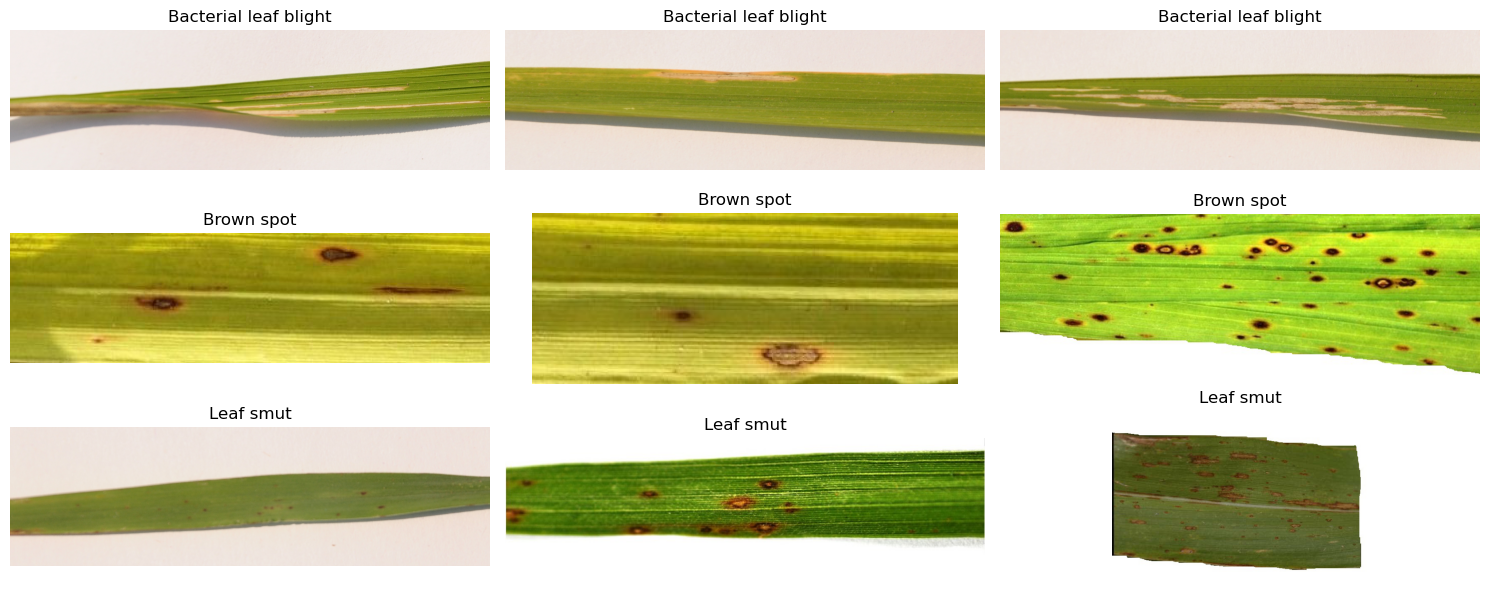

In [12]:
def show_samples(base_path, n=3):
    plt.figure(figsize=(15, 6))
    i = 1
    for class_name in class_names:
        class_path = os.path.join(base_path, class_name)
        image_list = os.listdir(class_path)
        sample_count = min(n, len(image_list))  # only pick what's available
        images = random.sample(image_list, sample_count)
        
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = mpimg.imread(img_path)
            plt.subplot(len(class_names), n, i)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
            i += 1
    plt.tight_layout()
    plt.show()

show_samples(base_dir)


### Check Image size Variations
to set the prorper target_size

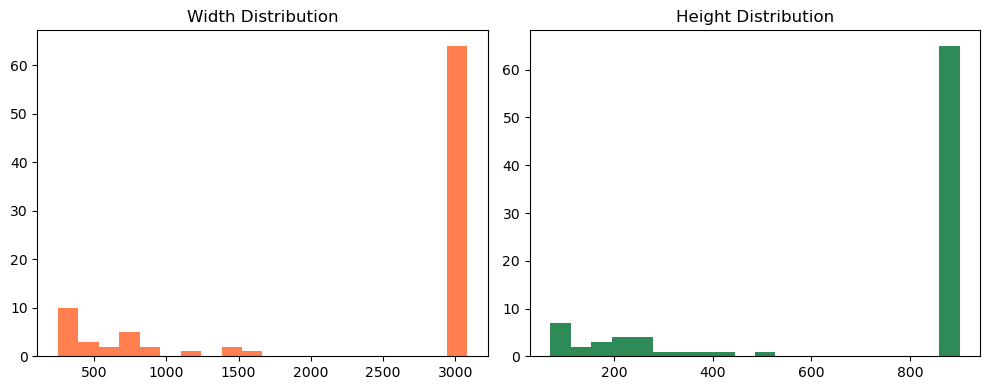

In [13]:
from PIL import Image

image_shapes = []

for class_name in class_names:
    class_path = os.path.join(base_dir, class_name)
    for img_name in os.listdir(class_path)[:30]:  # sample few images
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path)
            image_shapes.append(img.size)
        except:
            print(f"Couldn't read {img_path}")

# Plot width and height distribution
widths, heights = zip(*image_shapes)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='coral')
plt.title('Width Distribution')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='seagreen')
plt.title('Height Distribution')

plt.tight_layout()
plt.show()


### Detect for the corupt images

In [14]:
from PIL import UnidentifiedImageError

def check_corrupt_images(folder_path):
    corrupt = []
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        for img_file in os.listdir(cls_path):
            try:
                img = Image.open(os.path.join(cls_path, img_file))
                img.verify()
            except (UnidentifiedImageError, OSError):
                corrupt.append(os.path.join(cls_path, img_file))
    return corrupt

corrupt_images = check_corrupt_images(base_dir)
print(f"Found {len(corrupt_images)} corrupt images.")


Found 0 corrupt images.


In [ ]:
#Load  with Image Datagrnerator keras

In [22]:
base_dir = 'rice_leaf_dataset'

img_size = 128  
batch_size = 32
#data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,        # rotate images up to 20 degrees
    width_shift_range=0.1,    # shift width by 10%
    height_shift_range=0.1,   # shift height by 10%
    shear_range=0.1,          # shear intensity
    zoom_range=0.2,           # zoom in/out by 20%
    horizontal_flip=True,     # randomly flip images horizontally
    fill_mode='nearest',      #fill in empty pixels after transformation
    validation_split=0.2      #keep this for trian_val split
)

train_data = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 96 images belonging to 3 classes.
Found 23 images belonging to 3 classes.


### CNN Model Code

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [24]:
#create the model

In [25]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 128)      

### Train the model


In [26]:
history =model.fit(train_data,validation_data=val_data,epochs=50)

Epoch 1/50
3/3 [==============================] - 10s 3s/step - loss: 1.4728 - accuracy: 0.2500 - val_loss: 1.1140 - val_accuracy: 0.3043
Epoch 2/50
3/3 [==============================] - 8s 3s/step - loss: 1.1014 - accuracy: 0.3854 - val_loss: 1.0772 - val_accuracy: 0.3478
Epoch 3/50
3/3 [==============================] - 6s 2s/step - loss: 1.0912 - accuracy: 0.3542 - val_loss: 1.0677 - val_accuracy: 0.4348
Epoch 4/50
3/3 [==============================] - 6s 2s/step - loss: 1.0872 - accuracy: 0.4167 - val_loss: 1.0350 - val_accuracy: 0.6087
Epoch 5/50
3/3 [==============================] - 6s 2s/step - loss: 1.0518 - accuracy: 0.4375 - val_loss: 0.9573 - val_accuracy: 0.6087
Epoch 6/50
3/3 [==============================] - 6s 2s/step - loss: 0.9958 - accuracy: 0.4271 - val_loss: 0.8807 - val_accuracy: 0.7826
Epoch 7/50
3/3 [==============================] - 6s 2s/step - loss: 1.0356 - accuracy: 0.4271 - val_loss: 0.8389 - val_accuracy: 0.5652
Epoch 8/50
3/3 [========================

#### Plot the Accuracy and Loss

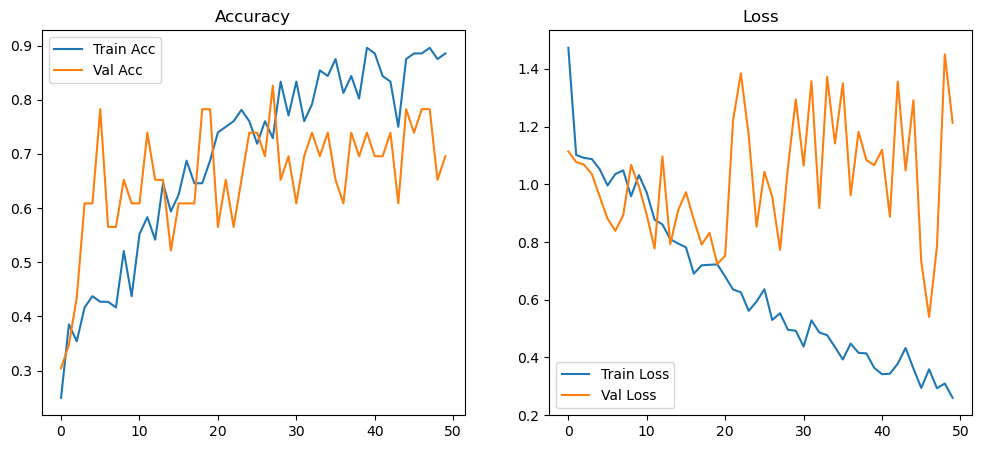

In [27]:
def plot_history(hist):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)


#### save the model

In [28]:
model.save("rice_leaf_disease_model.keras")
print("Model saved successfully!")


Model saved successfully!


###  Evaluation matrix

In [29]:
#Evaluation on the validate set
# Evaluate on validation/test set
loss, accuracy = model.evaluate(val_data)
print(f" Validation Accuracy: {accuracy:.2f}")
print(f" Validation Loss: {loss:.2f}")


1/1 [==============================] - 1s 1s/step - loss: 1.5129 - accuracy: 0.6522
 Validation Accuracy: 0.65
 Validation Loss: 1.51


####  ClassificationReport and ConfusionMatrix

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

1/1 [==============================] - 1s 1s/step
Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.29      0.25      0.27         8
           Brown spot       0.40      0.25      0.31         8
            Leaf smut       0.18      0.29      0.22         7

             accuracy                           0.26        23
            macro avg       0.29      0.26      0.27        23
         weighted avg       0.29      0.26      0.27        23



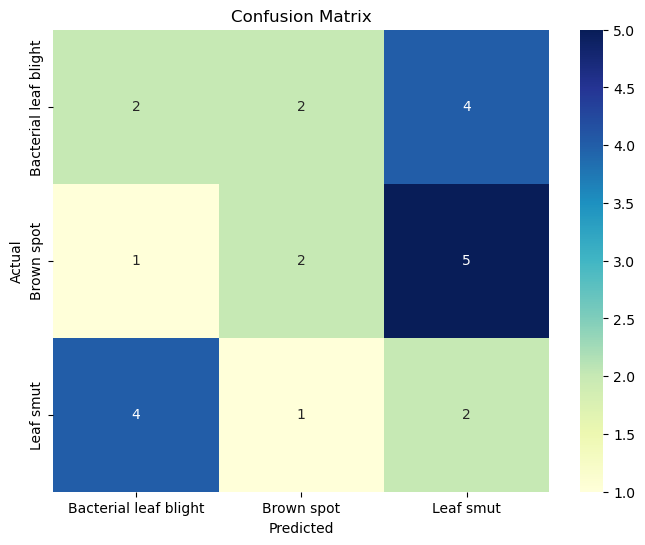

In [31]:
#  true labels & predictions
y_true = val_data.classes
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class labels
class_labels = list(val_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
